# Phase 1.5: Complete ML Metrics & MLflow Tracking

This comprehensive notebook demonstrates:
1. **Data Exploration** - Visualize and understand the wine dataset
2. **Model Training** - Train RandomForest with different hyperparameters
3. **Complete Metrics** - Learn ALL important ML evaluation metrics
4. **MLflow Tracking** - Log everything for comparison

## 🎯 Learning Goals
- Understand how machine learning models learn from data
- Master ALL important evaluation metrics
- See the difference between training and test data
- Use MLflow to track comprehensive experiments

## 📦 Step 1: Import Libraries

In [1]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.datasets import load_wine
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Import ALL important metrics
from sklearn.metrics import (
    # Basic Classification Metrics
    accuracy_score,           # Overall correctness: (Correct Predictions) / (Total Predictions)
    precision_score,          # "Quality" - Of all predicted positives, how many were actually positive? (Use when False Positives are expensive)
    recall_score,             # "Quantity" - Of all actual positives, how many did we find? (Use when False Negatives are expensive)
    f1_score,                 # Balance between Precision and Recall (Harmonic mean) - Best for imbalanced datasets
    
    # Advanced Classification Metrics
    roc_auc_score,            # Area Under Curve - Probability that model ranks a random positive higher than a random negative (0.5=random, 1.0=perfect)
    balanced_accuracy_score,  # Average recall of each class - Crucial when one class is much larger than the other
    matthews_corrcoef,        # MCC - Correlation between predicted and observed (-1 to +1). Considered mostly robust metric for binary classification.
    cohen_kappa_score,        # "Inter-rater reliability" - Agreement between model and truth, accounting for agreement by chance
    log_loss,                 # "Confidence penalty" - Punishes wrong predictions more if the model was confident about them
    
    # Confusion Matrix & Reports
    confusion_matrix,         # The raw grid: True Positives, True Negatives, False Positives, False Negatives
    classification_report,    # A ready-made text report showing Precision, Recall, and F1 for every class
    
    # Visualization Helpers
    ConfusionMatrixDisplay,   # Helper to draw the confusion matrix heatmap
    RocCurveDisplay,          # Helper to plot the ROC curve (True Positive Rate vs False Positive Rate)
    PrecisionRecallDisplay,   # Helper to plot Precision vs Recall Trade-off curve
)

import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ All libraries imported successfully!")
print("📊 Ready to explore comprehensive ML metrics!")

✅ All libraries imported successfully!
📊 Ready to explore comprehensive ML metrics!


## 🔗 Step 2: Connect to MLflow

In [2]:
TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI", "http://localhost:5000")
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment("wine-classification-experiment")

print(f"✅ Connected to MLflow at: {TRACKING_URI}")
print(f"📊 Experiment: wine-classification-experiment")

✅ Connected to MLflow at: http://localhost:5000
📊 Experiment: wine-classification-experiment


## 📊 Step 3: Load and Explore the wine Dataset

In [3]:
# Load the wine dataset from scikit-learn's built-in datasets
wine = load_wine()
# print(wine.data)
# print(wine.target)
# print(wine.feature_names)
# print(wine.target_names)
# Separate the data into features (X) and target/labels (y)
X = wine.data   # The 13 measurements for each wine (alcohol, malic acid, etc.)
y = wine.target # The class labels (0, 1, or 2) representing the wine cultivator
# Create a pandas DataFrame to organize the data in a table format
df = pd.DataFrame(X, columns=wine.feature_names)
# Add the class labels to the DataFrame
# Convert numeric codes (0, 1, 2) to readable names (class_0, class_1, class_2)
df['wine_class'] = pd.Categorical.from_codes(y, wine.target_names)
df['class_code'] = y # Keep the numeric codes as well for reference
# Print insights about the dataset
print(f"📊 Dataset Shape: {df.shape}") # Shows (number of rows, number of columns)
print(f"🍷 Features: {list(wine.feature_names)}") # Lists all 13 features
print(f"🏷️  Classes: {list(wine.target_names)}") # Lists the 3 classes
print(f"\n📋 First 5 rows:") # Shows the first 5 samples to check the data
df.head()

📊 Dataset Shape: (178, 15)
🍷 Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
🏷️  Classes: [np.str_('class_0'), np.str_('class_1'), np.str_('class_2')]

📋 First 5 rows:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class,class_code
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0,0


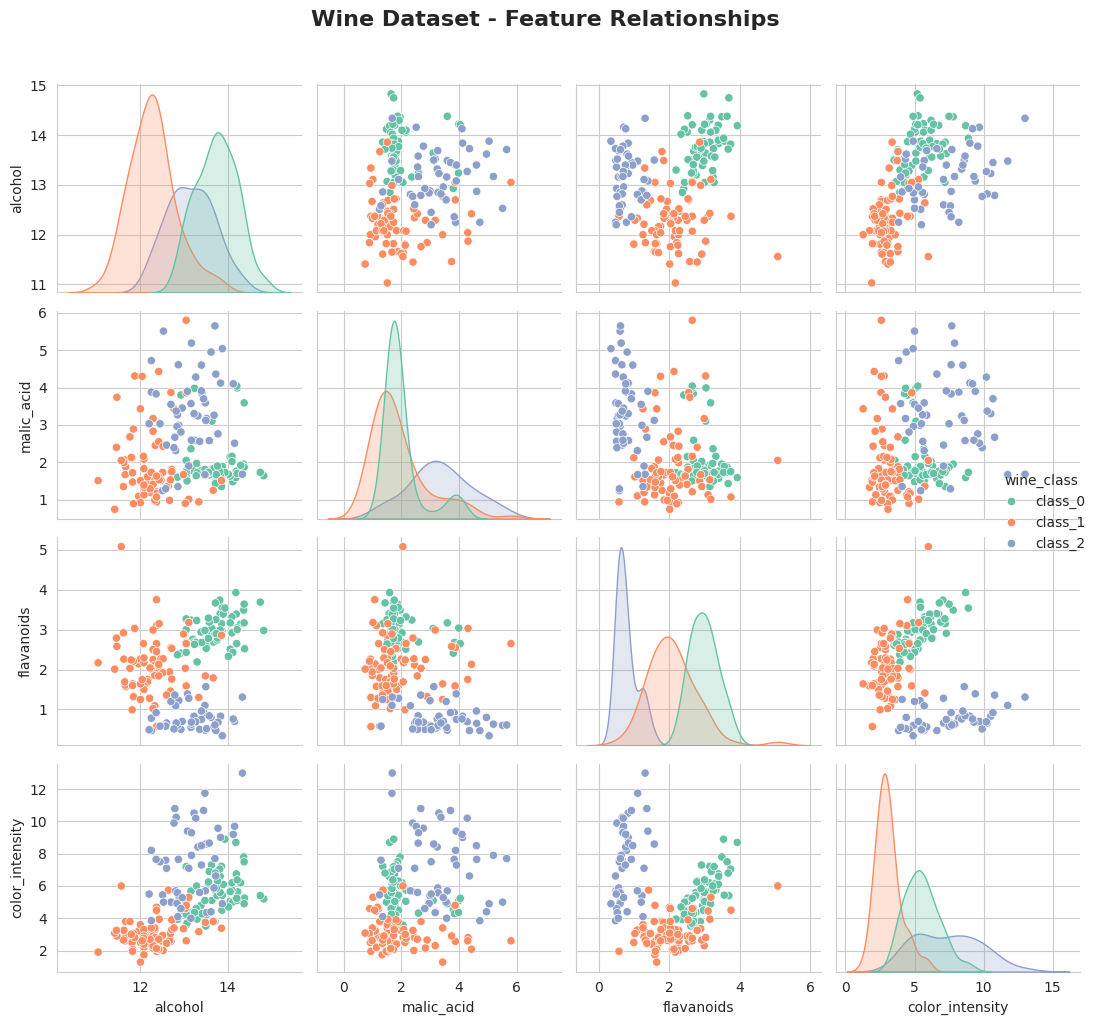

💡 Notice how different wine classes cluster together!


In [4]:
# Pairplot to see relationships (using subset of features for wine dataset - 13 features is too many)
# Select key features for visualization instead of using all 13
key_features = ['alcohol', 'malic_acid', 'flavanoids', 'color_intensity', 'wine_class']
# Create a smaller DataFrame with only the selected columns for cleaner plotting
df_subset = df[key_features]
# Create a pairplot: a grid of scatterplots showing every feature against every other feature
# hue='wine_class': Colors points differently based on wine cultivar
# palette='Set2': Uses a specific color scheme
# diag_kind='kde': Uses Kernel Density Estimate (smooth curves) for the diagonal plots instead of histograms
sns.pairplot(df_subset, hue='wine_class', palette='Set2', diag_kind='kde', height=2.5)
# Add a main title to the plot, positioned slightly above (y=1.02)
plt.suptitle('Wine Dataset - Feature Relationships', y=1.02, fontsize=16, fontweight='bold')
# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()
# Display the plot
plt.show()
print("💡 Notice how different wine classes cluster together!")

## ✂️ Step 4: Split Data

In [5]:
# Split the dataset into two parts:
# 1. Training set (to teach the model)
# 2. Testing set (to evaluate how well the model learned)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # Keep 20% of data for testing, use 80% for training
    random_state=42,  # Set a seed for reproducibility (so we get the same split every time)
    stratify=y        # Ensure the train/test sets have the same proportion of wine classes as the original data
)
print(f"✅ Data split complete!")
print(f"📊 Training: {len(X_train)} samples | Test: {len(X_test)} samples")

✅ Data split complete!
📊 Training: 142 samples | Test: 36 samples


## 🤖 Step 5: Train Model & Calculate ALL Metrics

Let's train a model and calculate EVERY important metric to understand what each one means!

In [6]:
# Initialize a Random Forest Classifier model
# Think of it as a collection (forest) of decision trees that vote on the final prediction
params = {
    "n_estimators": 50,      # Number of decision trees in the forest
    "max_depth": 5,          # Maximum depth of each tree (prevents overfitting)
    "min_samples_split": 2,  # Minimum samples required to split an internal node
    "random_state": 42       # Ensures reproducibility
}
model = RandomForestClassifier(**params)
# Train the model using the training data
# This is where the model "learns" the patterns between features and wine classes
model.fit(X_train, y_train)
# Use the trained model to make predictions on the unseen test data
# y_pred: The predicted class labels (e.g., 0, 1, or 2)
# y_pred_proba: The probability/confidence for each class prediction
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print("✅ Model trained!")
print(f"📊 Made predictions on {len(y_test)} test samples")

✅ Model trained!
📊 Made predictions on 36 test samples


## 📈 Step 6: Calculate & Understand ALL Metrics

### 🎯 Basic Metrics

In [7]:
# Print a header for the metrics section
print("=" * 80)
print("BASIC CLASSIFICATION METRICS")
print("=" * 80)

# 1. Accuracy: The simplest metric
# It simply measures the percentage of correct predictions
# accuracy_score compares the true labels (y_test) with predicted labels (y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n1️⃣ ACCURACY: {accuracy:.4f}")
print(f"   📖 What it means: {accuracy*100:.1f}% of predictions were correct")
print(f"   💡 Formula: (Correct Predictions) / (Total Predictions)")
print(f"   ⚠️  Limitation: Can be misleading with imbalanced classes")

# 2. Precision: Measure of exactness
# 'average=weighted' calculates metrics for each label, and finds their average weighted by support (the number of true instances for each label)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"\n2️⃣ PRECISION: {precision:.4f}")
print(f"   📖 What it means: When model predicts a class, it's correct {precision*100:.1f}% of the time")
print(f"   💡 Formula: (True Positives) / (True Positives + False Positives)")
print(f"   🎯 Use when: False positives are costly (e.g., spam detection)")

# 3. Recall (Sensitivity): Measure of completeness
# How many of the actual positive cases did we catch?
recall = recall_score(y_test, y_pred, average='weighted')
print(f"\n3️⃣ RECALL (Sensitivity): {recall:.4f}")
print(f"   📖 What it means: Model finds {recall*100:.1f}% of actual instances")
print(f"   💡 Formula: (True Positives) / (True Positives + False Negatives)")
print(f"   🎯 Use when: False negatives are costly (e.g., disease detection)")

# 4. F1 Score: The balance between Precision and Recall
# Useful when you need to balance false positives and false negatives
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n4️⃣ F1 SCORE: {f1:.4f}")
print(f"   📖 What it means: Harmonic mean of precision and recall")
print(f"   💡 Formula: 2 * (Precision * Recall) / (Precision + Recall)")
print(f"   🎯 Use when: You need balance between precision and recall")

BASIC CLASSIFICATION METRICS

1️⃣ ACCURACY: 1.0000
   📖 What it means: 100.0% of predictions were correct
   💡 Formula: (Correct Predictions) / (Total Predictions)
   ⚠️  Limitation: Can be misleading with imbalanced classes

2️⃣ PRECISION: 1.0000
   📖 What it means: When model predicts a class, it's correct 100.0% of the time
   💡 Formula: (True Positives) / (True Positives + False Positives)
   🎯 Use when: False positives are costly (e.g., spam detection)

3️⃣ RECALL (Sensitivity): 1.0000
   📖 What it means: Model finds 100.0% of actual instances
   💡 Formula: (True Positives) / (True Positives + False Negatives)
   🎯 Use when: False negatives are costly (e.g., disease detection)

4️⃣ F1 SCORE: 1.0000
   📖 What it means: Harmonic mean of precision and recall
   💡 Formula: 2 * (Precision * Recall) / (Precision + Recall)
   🎯 Use when: You need balance between precision and recall


### 🔬 Advanced Metrics

In [8]:
print("\n" + "=" * 80)
print("ADVANCED CLASSIFICATION METRICS")
print("=" * 80)

# 5. ROC AUC Score (Receiver Operating Characteristic - Area Under Curve)
# Measures how well the model can distinguish between classes
# multi_class='ovr': 'One-vs-Rest' strategy for multi-class problems
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\n5️⃣ ROC AUC SCORE: {roc_auc:.4f}")
print(f"   📖 What it means: Area under ROC curve - model's ability to separate classes")
print(f"   💡 Range: 0.5 (random) to 1.0 (perfect)")
print(f"   🎯 Use when: Evaluating probability predictions")

# 6. Balanced Accuracy
# Calculates accuracy for each class individually and then averages them
# This prevents the majority class from dominating the score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\n6️⃣ BALANCED ACCURACY: {balanced_acc:.4f}")
print(f"   📖 What it means: Accuracy adjusted for class imbalance")
print(f"   💡 Formula: Average of recall for each class")
print(f"   🎯 Use when: Classes are imbalanced")

# 7. Matthews Correlation Coefficient (MCC)
# A balanced measure that takes into account true and false positives and negatives
# Considered one of the best single-number metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"\n7️⃣ MATTHEWS CORRELATION COEFFICIENT: {mcc:.4f}")
print(f"   📖 What it means: Correlation between predictions and actual values")
print(f"   💡 Range: -1 (worst) to +1 (perfect), 0 (random)")
print(f"   🎯 Use when: Need a single metric that works well with imbalanced data")

# 8. Cohen's Kappa
# Measures how much better the model is compared to random guessing
# It accounts for agreements that could happen by chance
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\n8️⃣ COHEN'S KAPPA: {kappa:.4f}")
print(f"   📖 What it means: Agreement between predictions and actual, accounting for chance")
print(f"   💡 Range: -1 to +1, where 1 is perfect agreement")
print(f"   🎯 Use when: Want to account for random chance in predictions")

# 9. Log Loss (Cross-Entropy Loss)
# Measures how confident the model is in its correct predictions
# Penalizes the model heavily for being confident about a wrong answer
logloss = log_loss(y_test, y_pred_proba)
print(f"\n9️⃣ LOG LOSS: {logloss:.4f}")
print(f"   📖 What it means: Penalizes confident wrong predictions heavily")
print(f"   💡 Range: 0 (perfect) to infinity (worse)")
print(f"   🎯 Use when: Probability calibration matters")


ADVANCED CLASSIFICATION METRICS

5️⃣ ROC AUC SCORE: 1.0000
   📖 What it means: Area under ROC curve - model's ability to separate classes
   💡 Range: 0.5 (random) to 1.0 (perfect)
   🎯 Use when: Evaluating probability predictions

6️⃣ BALANCED ACCURACY: 1.0000
   📖 What it means: Accuracy adjusted for class imbalance
   💡 Formula: Average of recall for each class
   🎯 Use when: Classes are imbalanced

7️⃣ MATTHEWS CORRELATION COEFFICIENT: 1.0000
   📖 What it means: Correlation between predictions and actual values
   💡 Range: -1 (worst) to +1 (perfect), 0 (random)
   🎯 Use when: Need a single metric that works well with imbalanced data

8️⃣ COHEN'S KAPPA: 1.0000
   📖 What it means: Agreement between predictions and actual, accounting for chance
   💡 Range: -1 to +1, where 1 is perfect agreement
   🎯 Use when: Want to account for random chance in predictions

9️⃣ LOG LOSS: 0.0989
   📖 What it means: Penalizes confident wrong predictions heavily
   💡 Range: 0 (perfect) to infinity (wors

### 📊 Confusion Matrix - Visual Understanding


CONFUSION MATRIX


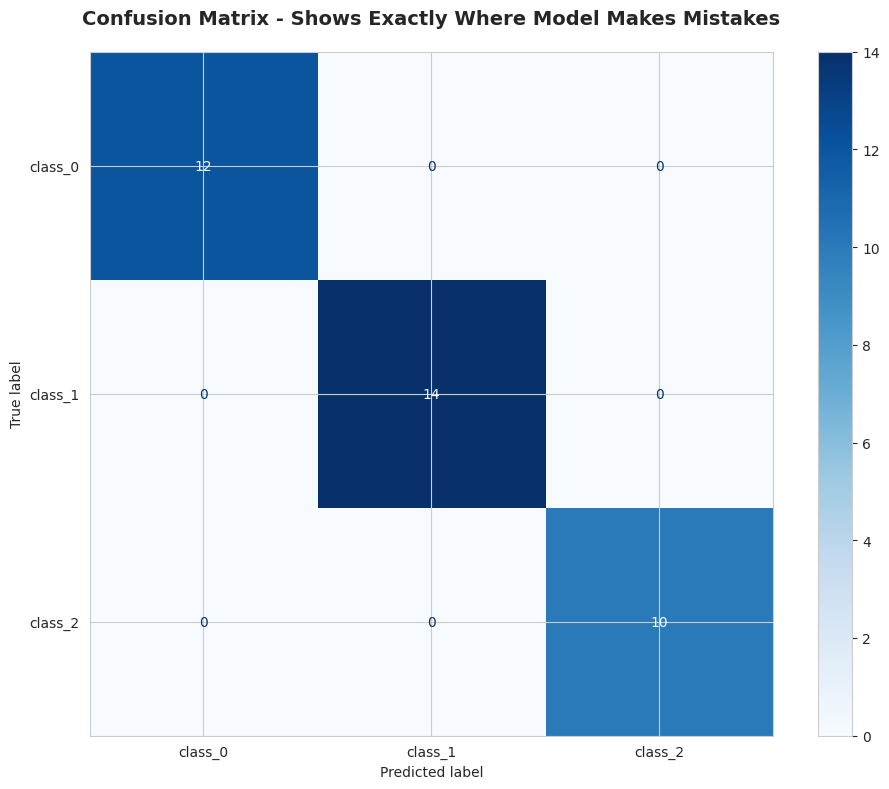


💡 How to read the Confusion Matrix:
   - Rows = Actual class
   - Columns = Predicted class
   - Diagonal = Correct predictions
   - Off-diagonal = Mistakes

📊 Confusion Matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]


In [9]:
# Print a header for the confusion matrix section
print("\n" + "=" * 80)
print("CONFUSION MATRIX")
print("=" * 80)

# Calculate the confusion matrix
# It compares actual values (y_test) with predicted values (y_pred)
# Result is a grid showing how many times class A was predicted as class B
cm = confusion_matrix(y_test, y_pred)

# Create a figure for plotting
# figsize=(10, 8) sets the width and height of the plot in inches
fig, ax = plt.subplots(figsize=(10, 8))

# Create a visual display of the confusion matrix
# display_labels maps the numeric class IDs back to their names (e.g., 'class_0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=wine.target_names)

# Draw the plot
# cmap='Blues': Uses shades of blue (darker = more predictions)
# values_format='d': Displays numbers as integers
disp.plot(cmap='Blues', ax=ax, values_format='d')

# Add a descriptive title
plt.title('Confusion Matrix - Shows Exactly Where Model Makes Mistakes', 
          fontsize=14, fontweight='bold', pad=20)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print a guide on how to interpret the confusion matrix
print("\n💡 How to read the Confusion Matrix:")
print("   - Rows = Actual class")
print("   - Columns = Predicted class")
print("   - Diagonal = Correct predictions")
print("   - Off-diagonal = Mistakes")
print(f"\n📊 Confusion Matrix:\n{cm}")

### 📋 Classification Report - Everything in One Place

In [10]:
# Print a header for the classification report section
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - Complete Per-Class Metrics")
print("=" * 80)

# Generate a detailed text report showing main classification metrics
# It calculates precision, recall, and f1-score for EACH class individually
# target_names provides the human-readable names for the classes
report = classification_report(y_test, y_pred, target_names=wine.target_names)
print(f"\n{report}")

# Print a guide on how to interpret the classification report metrics
print("\n💡 How to read the Classification Report:")
print("   - precision: Of all predicted X, how many were actually X?")
print("   - recall: Of all actual X, how many did we find?")
print("   - f1-score: Harmonic mean of precision and recall")
print("   - support: Number of actual instances of each class in the test set")


CLASSIFICATION REPORT - Complete Per-Class Metrics

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


💡 How to read the Classification Report:
   - precision: Of all predicted X, how many were actually X?
   - recall: Of all actual X, how many did we find?
   - f1-score: Harmonic mean of precision and recall
   - support: Number of actual instances of each class in the test set


### 🎨 ROC Curves - Visual Performance

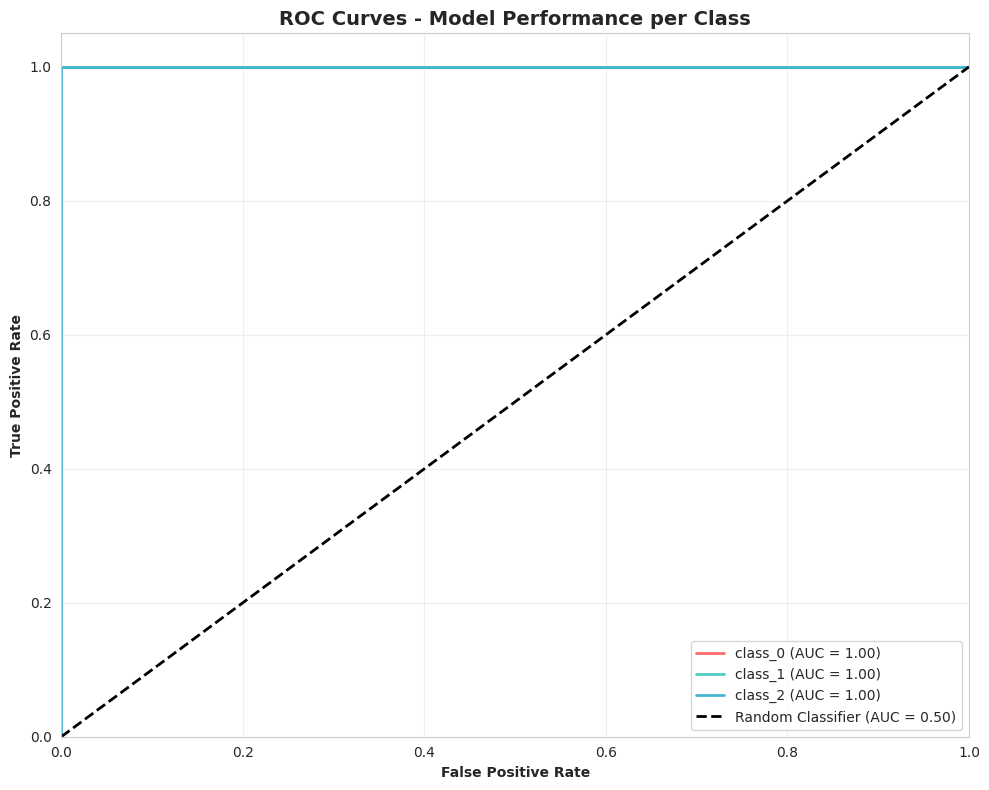

💡 How to read ROC Curves:
   - Closer to top-left corner = Better performance
   - AUC = 1.0: Perfect classifier
   - AUC = 0.5: Random guessing (diagonal line)
   - AUC < 0.5: Worse than random (doing something wrong!)


In [11]:
# Import helpers specifically for plotting custom ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Prepare data for Multi-class ROC plotting
# We convert class labels (0, 1, 2) into binary columns (one-hot encoding)
# e.g., Class 1 becomes [0, 1, 0]
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors for each class curve for better visibility
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Calculate and plot ROC curve for EACH class iteratively
# This treats each class as a binary problem (One-vs-Rest)
for i, color in zip(range(n_classes), colors):
    # Calculate False Positive Rate (fpr) and True Positive Rate (tpr) for class i
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    
    # Calculate the Area Under Curve (AUC) for this specific class
    roc_auc_class = auc(fpr, tpr)
    
    # Plot the curve for class i
    ax.plot(fpr, tpr, color=color, lw=2,
            label=f'{wine.target_names[i]} (AUC = {roc_auc_class:.2f})')

# Plot the diagonal line representing a purely random classifier (baseline)
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Set plot limit and labels
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')
ax.set_title('ROC Curves - Model Performance per Class', fontsize=14, fontweight='bold')

# Add legend and grid
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print a guide on how to interpret ROC curves
print("💡 How to read ROC Curves:")
print("   - Closer to top-left corner = Better performance")
print("   - AUC = 1.0: Perfect classifier")
print("   - AUC = 0.5: Random guessing (diagonal line)")
print("   - AUC < 0.5: Worse than random (doing something wrong!)")

## 🔄 Step 7: Cross-Validation - More Robust Evaluation

CROSS-VALIDATION SCORES

📊 5-Fold Cross-Validation Accuracy Scores:
   Fold 1: 0.9444
   Fold 2: 0.9444
   Fold 3: 0.9722
   Fold 4: 0.9714
   Fold 5: 1.0000

📈 Summary:
   Mean Accuracy: 0.9665
   Std Deviation: 0.0207

💡 What is Cross-Validation?
   - Splits data into K folds (here K=5)
   - Trains on K-1 folds, tests on remaining fold
   - Repeats K times, each fold used as test once
   - More reliable than single train/test split
   - Helps detect overfitting


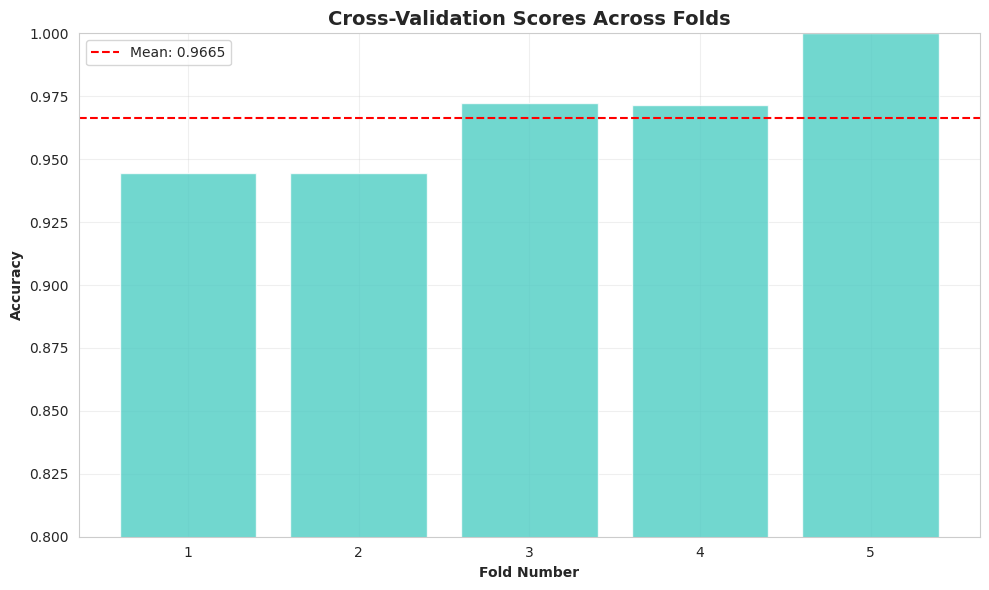

In [12]:
# Print a header for the cross-validation section
print("=" * 80)
print("CROSS-VALIDATION SCORES")
print("=" * 80)

# Perform 5-fold cross-validation
# cross_val_score automatically splits data into 5 parts
# It trains 5 separate models, each using a different 20% of data for testing
# This gives a more robust estimate of model performance than a single split
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print accuracy for each individual run (fold)
print(f"\n📊 5-Fold Cross-Validation Accuracy Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score:.4f}")

# Print summary statistics
print(f"\n📈 Summary:")
print(f"   Mean Accuracy: {cv_scores.mean():.4f}") # Average performance
print(f"   Std Deviation: {cv_scores.std():.4f}")  # How consistent is the performance?

# Print a guide on what cross-validation is
print(f"\n💡 What is Cross-Validation?")
print(f"   - Splits data into K folds (here K=5)")
print(f"   - Trains on K-1 folds, tests on remaining fold")
print(f"   - Repeats K times, each fold used as test once")
print(f"   - More reliable than single train/test split")
print(f"   - Helps detect overfitting")

# Visualize the scores for each fold to check for consistency
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='#4ECDC4', alpha=0.8) # Bar plot of scores

# Add a horizontal line for the mean accuracy
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')

# Add labels and formatting
plt.xlabel('Fold Number', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Cross-Validation Scores Across Folds', fontsize=14, fontweight='bold')
plt.legend()
plt.ylim([0.8, 1.0]) # Zoom in on the top range of accuracy
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 📊 Step 8: Log Everything to MLflow

In [13]:
# Start an MLflow run to group all logs together
# 'with' statement ensures the run is properly closed even if errors occur
with mlflow.start_run(run_name="wine-classification-run"):
    
    # 1. LOG DATASET (New in MLflow 2.0+)
    # This allows you to track exactly which data was used for training
    from mlflow.data.pandas_dataset import from_pandas
    
    # Reconstruct DataFrame from X_train and y_train arrays
    train_df = pd.DataFrame(X_train, columns=wine.feature_names)
    train_df["target"] = y_train
    
    # Create an MLflow Dataset object
    dataset = from_pandas(
        train_df, 
        source="sklearn.datasets.load_wine", # Where data came from
        name="wine_training_data",          # Name in MLflow UI
        targets="target"                    # Column predicting
    )
    # Log the dataset metadata to the run
    mlflow.log_input(dataset, context="training")
    
    print("✅ Dataset logged to MLflow!")

    # 2. LOG PARAMETERS
    # Saves configuration settings like n_estimators, max_depth, etc.
    mlflow.log_params(params)
    
    # 3. LOG METRICS
    # Saves numerical performance scores (Accuracy, F1, etc.)
    # These can be graphed and compared across runs
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("balanced_accuracy", balanced_acc)
    mlflow.log_metric("matthews_corrcoef", mcc)
    mlflow.log_metric("cohen_kappa", kappa)
    mlflow.log_metric("log_loss", logloss)
    mlflow.log_metric("cv_mean_accuracy", cv_scores.mean())
    mlflow.log_metric("cv_std_accuracy", cv_scores.std())
    
    # 4. LOG TAGS
    # Adds metadata labels to the run for filtering/searching
    mlflow.set_tag("model_type", "RandomForest")
    mlflow.set_tag("dataset", "Wine")
    mlflow.set_tag("metrics_logged", "complete")
    
    print("✅ All metrics logged to MLflow!")
    print(f"\n🌐 View in MLflow UI: {TRACKING_URI}")
    
    # 5. LOG & REGISTER MODEL
    # Saves the actual trained model file and adds it to Model Registry
    model_name = "wine-random-forest"
    
    mlflow.sklearn.log_model(
        model, 
        "model",
        registered_model_name=model_name # Automatically creates version in Model Registry
    )
    
    # Sleep briefly to ensure async registration completes before updating
    import time
    time.sleep(1)
    
    # 6. UPDATE MODEL DESCRIPTIONS
    # Use MlflowClient to update metadata of the registered model
    from mlflow.tracking import MlflowClient
    client = MlflowClient()
    
    # Find the version we just registered
    latest_versions = client.get_latest_versions(model_name, stages=["None"])
    if latest_versions:
        latest_version = latest_versions[0]
        version_num = latest_version.version
        
        # Add description to the specific version (e.g., "Version 1 trained on 2024-01-01")
        client.update_model_version(
            name=model_name,
            version=version_num,
            description="RandomForest classifier for Wine dataset with complete metrics"
        )
        
        # Add description to the overall model registration (e.g., "Main Wine Classifier")
        client.update_registered_model(
            name=model_name,
            description="Wine cultivar classification model using RandomForest"
        )
        
        # Add note to the RUN description (visible in Experiments list)
        run_description = f"Wine RF (v{version_num}) - Acc: {accuracy:.2%}, F1: {f1:.4f}"
        mlflow.set_tag("mlflow.note.content", run_description)
        
        # Add custom version tag
        mlflow.set_tag("mlflow.source.git.commit", f"v{version_num}")
        
        print(f"✅ Model registered: {model_name} v{version_num}")
        print(f"✅ Run Description set: {run_description}")
        print(f"✅ Version column set: v{version_num}")

✅ Dataset logged to MLflow!


2026/01/10 19:32:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ All metrics logged to MLflow!

🌐 View in MLflow UI: http://localhost:5000


2026/01/10 19:32:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'wine-random-forest' already exists. Creating a new version of this model...
2026/01/10 19:32:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: wine-random-forest, version 7
Created version '7' of model 'wine-random-forest'.


✅ Model registered: wine-random-forest v7
✅ Run Description set: Wine RF (v7) - Acc: 100.00%, F1: 1.0000
✅ Version column set: v7
🏃 View run wine-classification-run at: http://localhost:5000/#/experiments/12/runs/daa47fbaf9604c1aa31d239992de3efb
🧪 View experiment at: http://localhost:5000/#/experiments/12


## 🎯 Step 9: Metrics Summary & When to Use Each

In [14]:
# Create a DataFrame to neatly summarize all metrics
# This creates a table with Metric Name, Value, and Usage Guideline
metrics_summary = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Precision',
        'Recall',
        'F1 Score',
        'ROC AUC',
        'Balanced Accuracy',
        'Matthews Corr Coef',
        'Cohen Kappa',
        'Log Loss'
    ],
    'Value': [
        f"{accuracy:.4f}",
        f"{precision:.4f}",
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{roc_auc:.4f}",
        f"{balanced_acc:.4f}",
        f"{mcc:.4f}",
        f"{kappa:.4f}",
        f"{logloss:.4f}"
    ],
    'Best For': [
        'Balanced datasets, overall performance',
        'When false positives are costly',
        'When false negatives are costly',
        'Balance between precision & recall',
        'Probability predictions, ranking',
        'Imbalanced datasets',
        'Imbalanced data, single metric',
        'Inter-rater agreement',
        'Probability calibration'
    ]
})

# Display the summary table
print("\n" + "=" * 100)
print("METRICS SUMMARY - WHEN TO USE EACH METRIC")
print("=" * 100)
print(metrics_summary.to_string(index=False))

# Print final educational takeaways
print("\n" + "=" * 100)
print("KEY TAKEAWAYS")
print("=" * 100)
print("\n1️⃣ NO SINGLE METRIC IS PERFECT")
print("   - Always look at multiple metrics")
print("   - Choose metrics based on your problem")

print("\n2️⃣ UNDERSTAND THE TRADEOFFS")
print("   - High precision → Low false positives (but might miss some)")
print("   - High recall → Find everything (but more false alarms)")
print("   - F1 score → Balance between both")

print("\n3️⃣ CONTEXT MATTERS")
print("   - Medical diagnosis → Prioritize RECALL (don't miss diseases)")
print("   - Spam detection → Prioritize PRECISION (don't block real emails)")
print("   - Fraud detection → Balance with F1 SCORE")

print("\n4️⃣ USE CROSS-VALIDATION")
print("   - More reliable than single train/test split")
print("   - Helps detect overfitting")
print("   - Shows model stability")


METRICS SUMMARY - WHEN TO USE EACH METRIC
            Metric  Value                               Best For
          Accuracy 1.0000 Balanced datasets, overall performance
         Precision 1.0000        When false positives are costly
            Recall 1.0000        When false negatives are costly
          F1 Score 1.0000     Balance between precision & recall
           ROC AUC 1.0000       Probability predictions, ranking
 Balanced Accuracy 1.0000                    Imbalanced datasets
Matthews Corr Coef 1.0000         Imbalanced data, single metric
       Cohen Kappa 1.0000                  Inter-rater agreement
          Log Loss 0.0989                Probability calibration

KEY TAKEAWAYS

1️⃣ NO SINGLE METRIC IS PERFECT
   - Always look at multiple metrics
   - Choose metrics based on your problem

2️⃣ UNDERSTAND THE TRADEOFFS
   - High precision → Low false positives (but might miss some)
   - High recall → Find everything (but more false alarms)
   - F1 score → Balance bet

## 🎓 Summary

### What You Learned:

1. **9 Essential Metrics** 📊
   - Accuracy, Precision, Recall, F1 Score
   - ROC AUC, Balanced Accuracy, MCC, Cohen's Kappa, Log Loss
   - When to use each one

2. **Visual Tools** 📈
   - Confusion Matrix
   - ROC Curves
   - Classification Report

3. **Cross-Validation** 🔄
   - More reliable evaluation
   - Detects overfitting

4. **MLflow Integration** 🚀
   - Log all metrics automatically
   - Compare experiments
   - Track everything

### Next Steps:
1. Open MLflow UI and compare all your experiments
2. Try different hyperparameters in the interactive cell
3. Apply these metrics to your own datasets!

In [15]:
print("🎉 Complete Metrics Notebook Finished!")
print(f"\n🌐 View all experiments: {TRACKING_URI}")
print("\n💡 You now understand ALL major ML evaluation metrics!")

🎉 Complete Metrics Notebook Finished!

🌐 View all experiments: http://localhost:5000

💡 You now understand ALL major ML evaluation metrics!
